## import 

In [3]:
!python -m pip install polars

/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/pty.py:89: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

If you really know what your doing, you can silence this warning with the warning module
or by setting POLARS_ALLOW_FORKING_THREAD=1.

  pid, fd = os.forkpty()


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
import scipy.stats as stats
import polars as pl

In [6]:
# calc lowerbound based on sampled sentences
grammar_names = [
    "Base",
    "DeterministicShuffle",
    "NonDeterministicShuffle",
    "LocalShuffle",
    "EvenOddShuffle",
    "NoReverse",
    "PartialReverse",
    "FullReverse",
]
results_dir = Path("../results").resolve()
dataset_dir = Path("../data/fairseq_train/eos_zipf_min1_max_20").resolve()
total_count = 100_000_000
split_num = 10
lower_bound_complexity = []
for grammar_name in grammar_names:
    counts_file = (
        results_dir
        / "length_sampling"
        / f"100M_samples_eos_zipf_min1_max20{'_' + grammar_name if grammar_name != 'Base' else ''}"
        / "sample_counts.csv.gz"
    )
    counts_df = pl.read_csv(counts_file, new_columns=["sentence", "count"])
    counts_df = counts_df.with_columns(
        (pl.col("count") / total_count).alias("probability")
    )

    # 各スプリットごとに計算
    for split_i in range(split_num):
        sentences_in_data = []
        split_file = dataset_dir / grammar_name / f"split_{split_i}.test"
        with open(split_file, "r") as f:
            sentences_in_data.extend(
                [line.strip() + " [eos]" for line in f.readlines()]
            )

        # データに含まれるsentenceの確率を取得
        sentences_in_data = pl.DataFrame({"sentence": sentences_in_data})
        sentences_in_data = sentences_in_data.join(counts_df, on="sentence", how="left")
        assert sentences_in_data["probability"].null_count() == 0

        # スプリットごとのlower boundを計算
        entropy = stats.entropy(sentences_in_data["probability"].to_numpy(), base=2)
        perplexity = 2**entropy
        lower_bound_complexity.append(
            {
                "grammar_name": f"{grammar_name}_split_{split_i}",
                "grammar_base": grammar_name,  # 元のgrammar名も保持
                "split": split_i,
                "lower_bound_entropy": entropy,
                "lower_bound_perplexity": perplexity,
            }
        )

In [7]:
grammar_names = [
    "Base",
    "DeterministicShuffle",
    "NonDeterministicShuffle",
    "LocalShuffle",
    "EvenOddShuffle",
    "NoReverse",
    "PartialReverse",
    "FullReverse",
]
num_splits = 10
model_names = ["lstm", "transformer"]
results_dir = Path("../results").resolve()

lower_bound_df = pd.DataFrame(lower_bound_complexity)

result_list = []
for grammar_name in grammar_names:
    for model_name in model_names:
        model_result_dir = results_dir / f"{model_name}_results"
        grammar_result_dir = model_result_dir / grammar_name

        # 各スプリットごとに計算
        for split_i in range(num_splits):
            split_result_file = grammar_result_dir / f"split_{split_i}.test.scores.txt"
            with open(split_result_file) as f:
                scores = [float(line.strip()) for line in f]
            grammar_probs = [np.exp(score) for score in scores]
            entropy = stats.entropy(grammar_probs, base=2)
            perplexity = 2**entropy

            # Lower boundを取得
            lower_bound = lower_bound_df[
                (lower_bound_df["grammar_base"] == grammar_name)
                & (lower_bound_df["split"] == split_i)
            ].iloc[0]

            delta_entropy = entropy - lower_bound["lower_bound_entropy"]
            delta_perplexity = perplexity - lower_bound["lower_bound_perplexity"]

            result_list.append(
                {
                    "model_name": model_name,
                    "grammar_name": f"{grammar_name}_split_{split_i}",
                    "grammar_base": grammar_name,
                    "split": split_i,
                    "entropy": entropy,
                    "perplexity": perplexity,
                    "delta_entropy": delta_entropy,
                    "delta_perplexity": delta_perplexity,
                }
            )

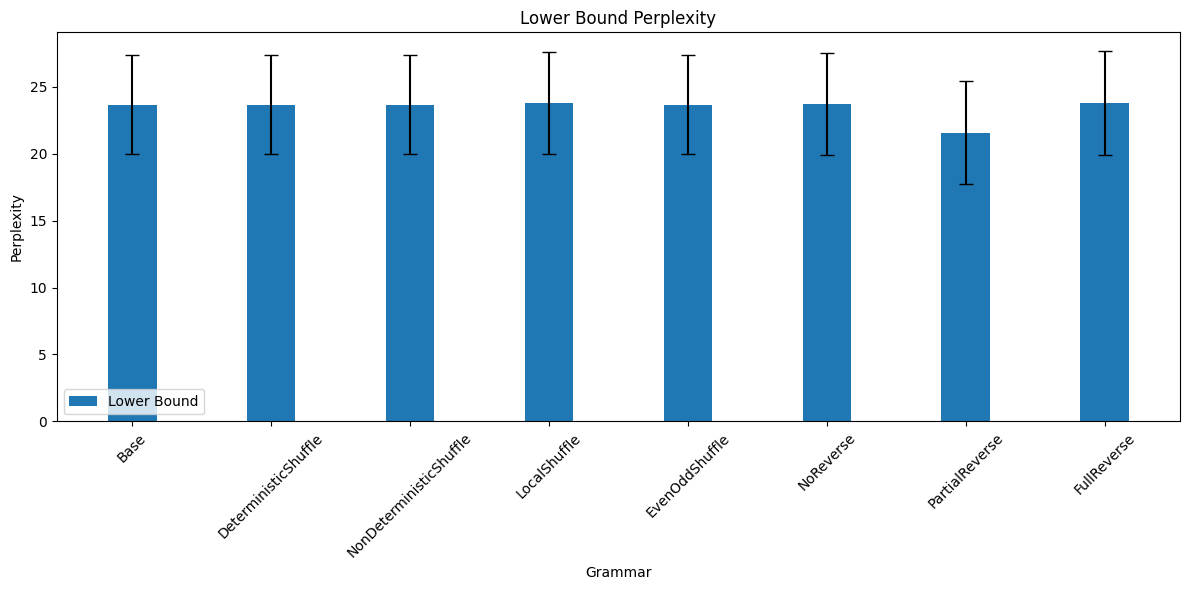

In [9]:
# Lower boundの集計
lower_bound_df = pd.DataFrame(lower_bound_complexity)
lower_bound_agg = (
    lower_bound_df.groupby("grammar_base")
    .agg({"lower_bound_perplexity": ["mean", "std"]})
    .reset_index()
)

# プロット
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35

# Lower Bound Perplexity plot
means = lower_bound_agg[("lower_bound_perplexity", "mean")]
stds = lower_bound_agg[("lower_bound_perplexity", "std")]
ax.bar(
    np.arange(len(grammar_names)),
    means,
    bar_width,
    label="Lower Bound",
    yerr=stds,
    capsize=5,
)

ax.set_xticks(np.arange(len(grammar_names)))
ax.set_xticklabels(grammar_names, rotation=45)
ax.set_title("Lower Bound Perplexity")
ax.set_xlabel("Grammar")
ax.set_ylabel("Perplexity")
ax.legend()

plt.tight_layout()
plt.show()

In [18]:
# Lower boundの集計
lower_bound_df = pd.DataFrame(lower_bound_complexity)
lower_bound_agg = (
    lower_bound_df.groupby("grammar_base")
    .agg({"lower_bound_perplexity": ["mean", "std"]})
    .reset_index()
)

# 平均と標準誤差を出力
for index, row in lower_bound_agg.iterrows():
    grammar_base = row["grammar_base"].iloc[0]
    mean_perplexity = row[("lower_bound_perplexity", "mean")]
    std_error = row[("lower_bound_perplexity", "std")] / (
        num_splits**0.5
    )  # 標準誤差 = 標準偏差 / sqrt(n)

    print(
        f"Grammar: {grammar_base}, Mean Perplexity: {mean_perplexity:.2f}, Standard Error: {std_error:.2f}"
    )

Grammar: Base, Mean Perplexity: 23.68, Standard Error: 1.17
Grammar: DeterministicShuffle, Mean Perplexity: 23.68, Standard Error: 1.17
Grammar: EvenOddShuffle, Mean Perplexity: 23.68, Standard Error: 1.17
Grammar: FullReverse, Mean Perplexity: 23.78, Standard Error: 1.21
Grammar: LocalShuffle, Mean Perplexity: 23.68, Standard Error: 1.17
Grammar: NoReverse, Mean Perplexity: 23.73, Standard Error: 1.21
Grammar: NonDeterministicShuffle, Mean Perplexity: 21.58, Standard Error: 1.21
Grammar: PartialReverse, Mean Perplexity: 23.81, Standard Error: 1.23


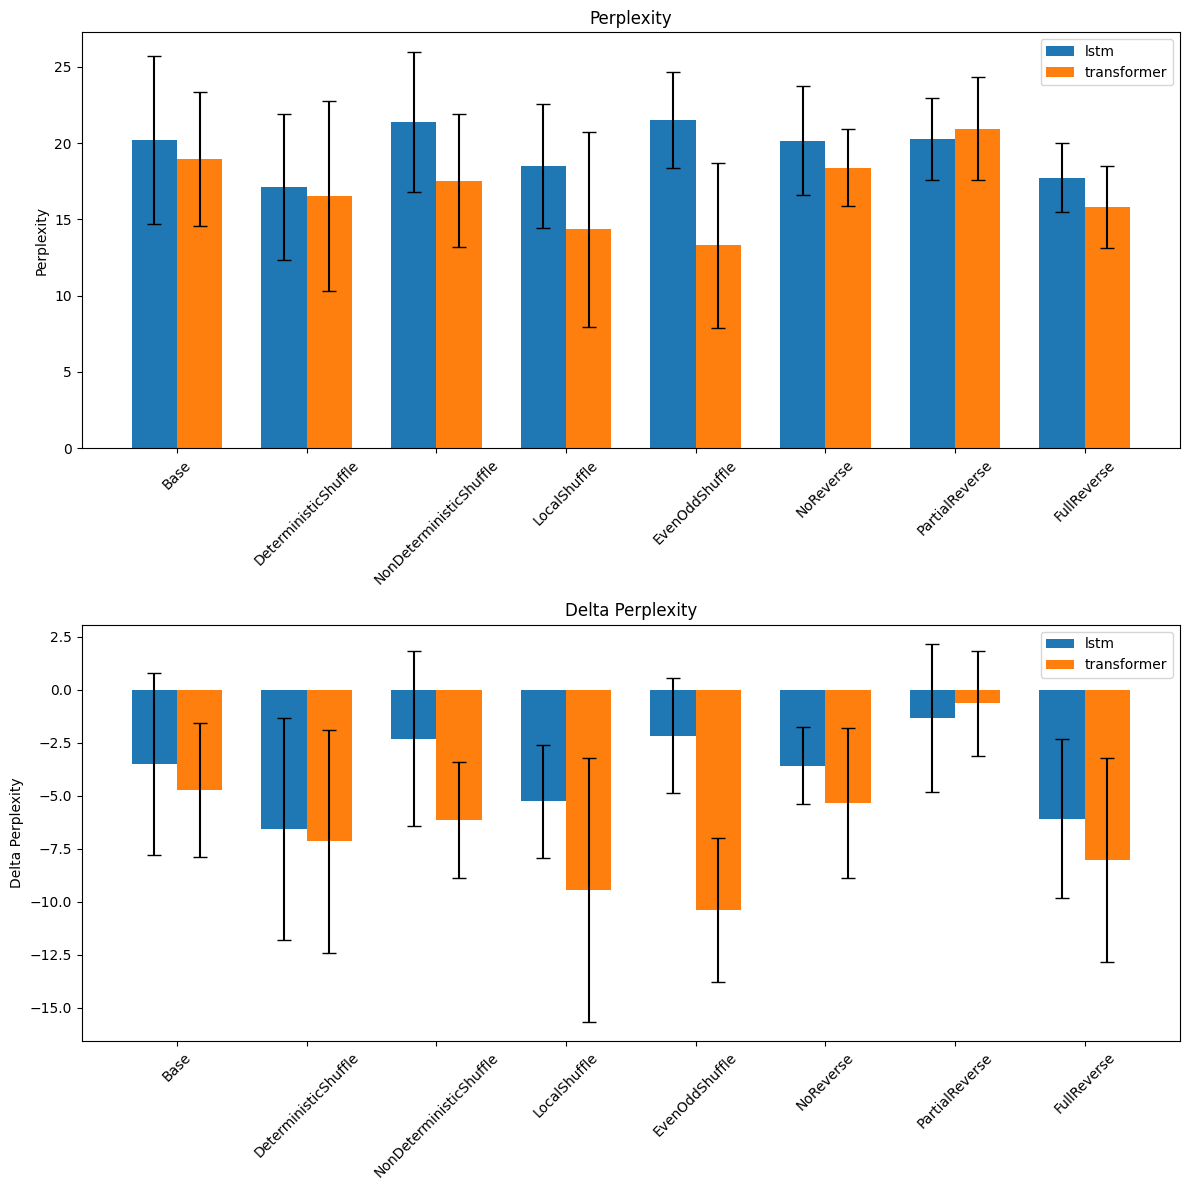

In [10]:
# DataFrameに変換してから集計
result_df = pd.DataFrame(result_list)
agg_result = (
    result_df.groupby(["model_name", "grammar_base"])
    .agg({"perplexity": ["mean", "std"], "delta_perplexity": ["mean", "std"]})
    .reset_index()
)

# プロット
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
bar_width = 0.35

for i, model_name in enumerate(model_names):
    model_results = agg_result[agg_result["model_name"] == model_name]

    # Perplexity plot
    means = model_results[("perplexity", "mean")]
    stds = model_results[("perplexity", "std")]
    ax[0].bar(
        np.arange(len(grammar_names)) + i * bar_width,
        means,
        bar_width,
        label=model_name,
        yerr=stds,
        capsize=5,
    )

    # Delta Perplexity plot
    delta_means = model_results[("delta_perplexity", "mean")]
    delta_stds = model_results[("delta_perplexity", "std")]
    ax[1].bar(
        np.arange(len(grammar_names)) + i * bar_width,
        delta_means,
        bar_width,
        label=model_name,
        yerr=delta_stds,
        capsize=5,
    )

# Set labels and legends
for a in ax:
    a.set_xticks(np.arange(len(grammar_names)) + bar_width / 2)
    a.set_xticklabels(grammar_names, rotation=45)
    a.legend()

ax[0].set_title("Perplexity")
ax[0].set_ylabel("Perplexity")

ax[1].set_title("Delta Perplexity")
ax[1].set_ylabel("Delta Perplexity")

plt.tight_layout()
plt.show()